In [28]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pathlib import Path
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Add digehealth_assessment folder to sys.path to allow imports from it
import sys
from pathlib import Path

digehealth_path = Path().resolve().parent / "digehealth_assessment"
if str(digehealth_path) not in sys.path:
    sys.path.append(str(digehealth_path))

# Debug: List files in digehealth_assessment to check for preprocessing.py
print("Files in digehealth_assessment:", list(digehealth_path.iterdir()))

from preprocessing import (
    extract_overlapping_segments,
    extract_features,
    load_and_normalize_wav,
)
from config import EXTERNAL_DATA_DIR

Files in digehealth_assessment: [WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/config.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/dataset.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/features.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/inference.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/modeling'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/plots.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/preprocessing.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/train_model.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/__init__.py'), WindowsPath('D:/Files/Projects/Code/digehealth-assessment/digehealth_assessment/__pycache__')]


In [20]:
# List of (wav, annotation) file pairs
file_pairs = [
    (
        EXTERNAL_DATA_DIR / "Tech Test" / "23M74M.wav",
        EXTERNAL_DATA_DIR / "Tech Test" / "23M74M.txt",
    ),
    (
        EXTERNAL_DATA_DIR / "Tech Test" / "AS_1.wav",
        EXTERNAL_DATA_DIR / "Tech Test" / "AS_1.txt",
    ),
]

In [21]:
all_segments = []
all_labels = []
all_sample_rates = []

print("Loading and segmenting audio files...")
for wav_path, ann_path in file_pairs:
    print(f"  Processing {wav_path.name} ...")
    wav_y, sample_rate = load_and_normalize_wav(wav_path)
    segments, labels = extract_overlapping_segments(
        wav_path=wav_path, annotation_path=ann_path
    )
    all_segments.extend(segments)
    all_labels.extend(labels)
    all_sample_rates.extend([sample_rate] * len(segments))

# Only keep 'b', 'mb', 'h' and 'n' labels, convert all remaining labels to 'n'
allowed_labels = {"b", "mb", "h", "n", "silence"}
all_labels = [label if label in allowed_labels else "n" for label in all_labels]

Loading and segmenting audio files...
  Processing 23M74M.wav ...
  Processing AS_1.wav ...


In [22]:
print("Extracting features from all segments...")
X = np.array(
    [
        extract_features(seg, sample_rate=sr)
        for seg, sr in zip(all_segments, all_sample_rates)
    ]
)
y = np.array(all_labels)

print(X.shape, y.shape)

Extracting features from all segments...
(10049, 28) (10049,)


In [ ]:
# Count and print all samples in each class before train/test split
unique, counts = np.unique(y, return_counts=True)
print("Class distribution BEFORE train/test split:")
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")

print("\nSplitting into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Count and print all samples in each class after train/test split
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nClass distribution in TRAIN set:")
for label, count in zip(unique_train, counts_train):
    print(f"  {label}: {count}")

Class distribution BEFORE train/test split:
  b: 488
  h: 303
  mb: 1884
  n: 7374
Splitting into train and test sets...

Class distribution in TRAIN set:
  b: 390
  h: 243
  mb: 1507
  n: 5899


In [24]:
print("Standardizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Standardizing features...


In [25]:
print("Balancing training data...")
target_size = int(np.median(counts_train))
# Determine which classes need undersampling and which need oversampling
class_counts = dict(zip(unique_train, counts_train))
under_classes = {
    label: target_size for label, count in class_counts.items() if count > target_size
}
over_classes = {
    label: target_size for label, count in class_counts.items() if count < target_size
}

# Step 1: Undersample majority classes
under = (
    RandomUnderSampler(sampling_strategy=under_classes, random_state=42)
    if under_classes
    else None
)

# Step 2: Oversample minority classes
smote = SMOTE(sampling_strategy=over_classes, random_state=42) if over_classes else None

# Build pipeline dynamically
steps = []
if under:
    steps.append(("under", under))
if smote:
    steps.append(("smote", smote))

if steps:
    pipeline = Pipeline(steps=steps)
    X_res, y_res = pipeline.fit_resample(X_train, y_train)
else:
    X_res, y_res = X_train, y_train

# For consistency with rest of code
X_train_bal, y_train_bal = X_res, y_res

print("\nClass distribution in TRAIN set after balancing:")
unique_train_bal, counts_train_bal = np.unique(y_train_bal, return_counts=True)
for label, count in zip(unique_train_bal, counts_train_bal):
    print(f"  {label}: {count}")

Balancing training data...

Class distribution in TRAIN set after balancing:
  b: 948
  h: 948
  mb: 948
  n: 948


In [26]:
print("Training classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_bal, y_train_bal)

print("Evaluating on test set...")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Training classifier...
Evaluating on test set...
              precision    recall  f1-score   support

           b       0.23      0.68      0.35        98
           h       0.47      0.77      0.58        60
          mb       0.57      0.68      0.62       377
           n       0.96      0.77      0.85      1475

    accuracy                           0.75      2010
   macro avg       0.56      0.72      0.60      2010
weighted avg       0.84      0.75      0.78      2010



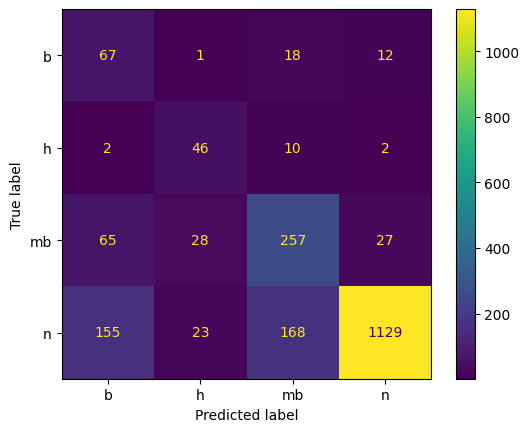

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= unique_train_bal)
disp.plot()
plt.show()